![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Vanilla RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainVanillaRNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchinfo

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/11_RNN/DeepLearningFramework ./DeepLearningFramework

### PyTorch `PackedSequence`:

In [4]:
from torch.nn.utils.rnn import pack_sequence

v1 = torch.tensor([1, 2, 3])
v2 = torch.tensor([4])
v3 = torch.tensor([5, 6])
lV = [v1, v2 ,v3]

pack = pack_sequence(lV, enforce_sorted=False)
print('pack.data          :', pack.data)
print('pack.batch_sizes   :', pack.batch_sizes)
print('pack.sorted_indices:', pack.sorted_indices)

pack.data          : tensor([1, 5, 4, 2, 6, 3])
pack.batch_sizes   : tensor([3, 2, 1])
pack.sorted_indices: tensor([0, 2, 1])


### Basic example
* Random data with random length.
* The goal is to estimate the sequence's length.

#### Generate data:

In [5]:
#-- Min and max lengths:
minL   = 2
maxL   = 100

nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

#-- Generate random lengths:
lX = [None] * N
vY = torch.randint(minL, maxL, (N,))
for ii in range(N):
    vXi    = torch.randn(vY[ii], 1)
    lX[ii] = vXi

#### Dataset:

In [6]:
#-- A simple sequence dataset:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, lX, vY):
        self.lX = lX
        self.vY = vY
        
    def __len__(self):
        return len(self.lX)
    
    def __getitem__(self, idx):
        vXi = self.lX[idx]
        yi  = self.vY[idx]
        return vXi, yi

In [7]:
from torch.utils.data import random_split

oDataset            = SequenceDataset(lX, vY.float())
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(50000, 10000)

#### Data loader:
We gonna use `zip` to implement the `collate_fn`

In [8]:
l = [('x1', 'y1'), ('x2', 'y2'), ('x3', 'y3')]
l1, l2 = zip(*l)
l1, l2

(('x1', 'x2', 'x3'), ('y1', 'y2', 'y3'))

In [9]:
def SequenceCollateFunction(lBatch):
    
    lX, lY = zip          (*lBatch)
    vY     = torch.stack  (lY)
    mPackX = pack_sequence(lX, enforce_sorted=False)
    
    return mPackX, vY


batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=SequenceCollateFunction)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollateFunction)

In [10]:
mPackX, vY = next(iter(oTrainDL))

mPackX, vY.shape

(PackedSequence(data=tensor([[-0.5452],
         [-0.3555],
         [ 0.0842],
         ...,
         [-1.0219],
         [-0.4409],
         [ 0.4976]]), batch_sizes=tensor([128, 128, 126, 124, 123, 123, 121, 119, 117, 116, 114, 114, 112, 111,
         108, 106, 105, 101,  99,  93,  92,  89,  89,  86,  86,  85,  84,  83,
          80,  79,  78,  77,  76,  76,  72,  71,  71,  69,  69,  69,  67,  66,
          66,  65,  63,  63,  62,  58,  56,  56,  56,  56,  56,  55,  55,  54,
          53,  53,  53,  53,  50,  47,  46,  45,  44,  43,  42,  40,  39,  38,
          36,  35,  33,  32,  29,  27,  25,  23,  22,  19,  18,  18,  16,  15,
          13,  11,  11,  11,  11,  11,   9,   5,   3,   2,   2,   1]), sorted_indices=tensor([101,  81, 116,   2,  97, 104,  96,  40,  89,  22,  95,  58,  67,  31,
         100,   6,  35,  45,  21,  13,  57,  27,   5, 103, 114,  69, 120,  46,
          37,  36,  56,  26,  79, 112,  16,  20, 124,  24, 113,  98,  10, 108,
          62,  50,  82,  29,  33,  72

### RNN Model:

In [11]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H         = 80
        self.oRnn = nn.RNN   (input_size=1, hidden_size=H, batch_first=True)
        self.oFC  = nn.Linear(H, 1)

    def forward(self, mPackX):
                                   #-- mPackX.shape = (N*T,)
        _, mH  = self.oRnn(mPackX) #-- mH    .shape = (1, N, H)
        vY     = self.oFC (mH[0])  #-- vY    .shape = (N, 1)
        
        return vY[:,0]
#-------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
mPackX, vY = next(iter(oTrainDL))

RnnModel()(mPackX).shape

torch.Size([128])

#### Device, loss, metric:

In [12]:
from DeepLearningFramework.Metric import R2Score

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.MSELoss()
Metric = R2Score

### Train the model:

In [13]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel

nEpochs    = 30
nIter      = nEpochs * len(oTrainDL)

oModel     = RnnModel  ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=5e-6, betas=(0.8, 0.9))
oScheduler = OneCycleLR(oOptim, max_lr=5e-4, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler);

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss: 3317.869 | Val loss: 3204.784 | Train Metric: -3.177 | Val Metric: -3.010 | epoch time:  2.703 | <-- Checkpoint!
Epoch 001: | Train loss: 3067.739 | Val loss: 2843.727 | Train Metric: -2.864 | Val Metric: -2.558 | epoch time:  2.079 | <-- Checkpoint!
Epoch 002: | Train loss: 2737.200 | Val loss: 2528.494 | Train Metric: -2.450 | Val Metric: -2.163 | epoch time:  2.085 | <-- Checkpoint!
Epoch 003: | Train loss: 2398.642 | Val loss: 2103.187 | Train Metric: -2.018 | Val Metric: -1.631 | epoch time:  2.082 | <-- Checkpoint!
Epoch 004: | Train loss: 2299.637 | Val loss: 2581.148 | Train Metric: -1.894 | Val Metric: -2.230 | epoch time:  2.080 |
Epoch 005: | Train loss: 2606.980 | Val loss: 2200.862 | Train Metric: -2.289 | Val Metric: -1.755 | epoch time:  2.067 |
Epoch 006: | Train loss: 2215.021 | Val loss: 1134.654 | Train Metric: -1.784 | Val

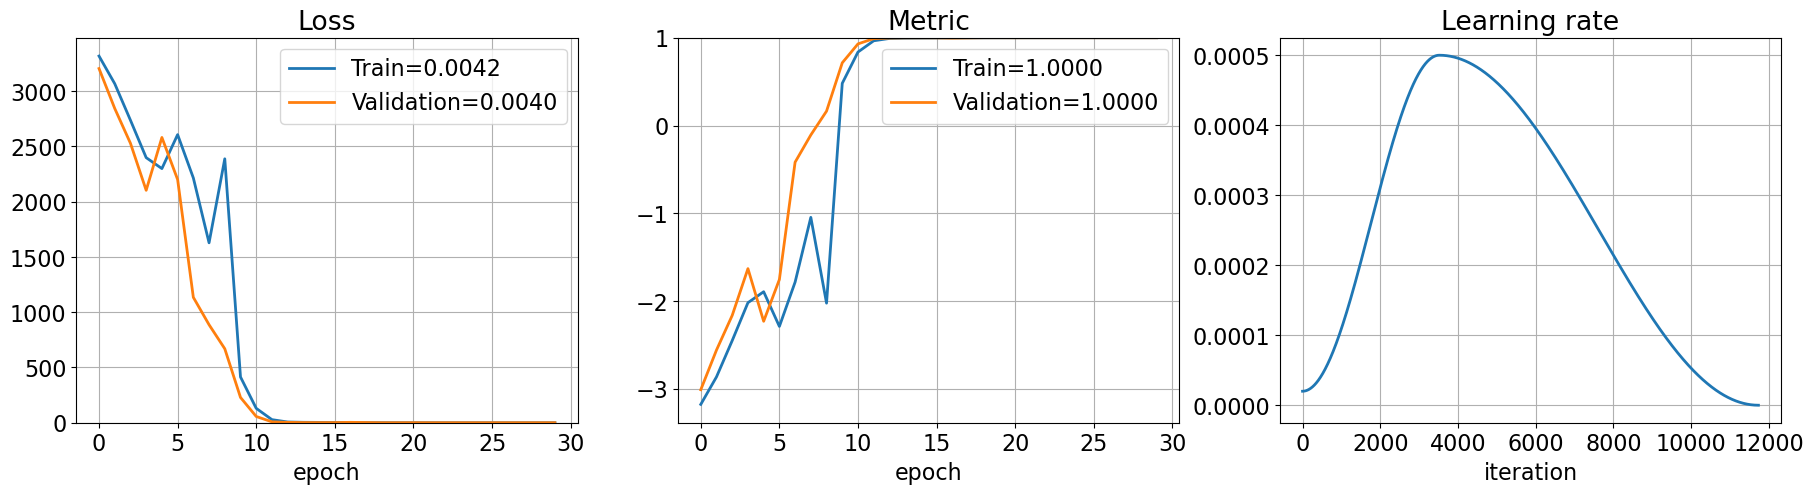

In [14]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Test the model:

In [15]:
L  = np.random.randint(minL, maxL)
vX = pack_sequence([torch.randn(L, 1)])
y  = oModel(vX.to(DEVICE))
print(f'Sequence length           = {L}')
print(f'Estimated sequence length = {y.item()}')

Sequence length           = 2
Estimated sequence length = 2.029033899307251


### Exercise
* The goal is to estimate the following function:
![f_x](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN//f_x.png?raw=true)
* Train an RNN model and get $R^2$ above `0.99`.

#### Generate data:

In [16]:
minL   = 5
maxL   = 30
nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

vY = torch.zeros(N)
lX = [None] * N
for ii in range(N):
    L       = np.random.randint(minL, maxL)
    vX      = torch.rand(L, 1)
    idx     = np.random.randint(L)
    vX[idx] = -1
    lX[ii]  = vX
    vY[ii]  = torch.sum(vX[:idx]**2) - torch.sum(vX[idx+1:]**2)

In [17]:
from torch.utils.data import random_split

oDataset            = SequenceDataset(lX, vY.float())
oTrainSet, oTestSet = ???

len(oTrainSet), len(oTestSet)

SyntaxError: invalid syntax (<ipython-input-17-ea20ea0c733f>, line 4)

In [ ]:
batchSize = ???
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=???)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=???)

### Model:

In [ ]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H         = 100
        self.oRnn = nn.RNN   (input_size=1, hidden_size=H, batch_first=True)
        self.oFC  = nn.Linear(H, 1)

    def forward(self, mPackX):
        ???

#-------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
mPackX, vY = next(iter(oTrainDL))

RnnModel()(mPackX).shape

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = ???
Metric = ???

In [ ]:
from torch.optim                    import lr_scheduler
from DeepLearningFramework.Training import TrainRegressionModel

nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)
oModel        = RnnModel().to(DEVICE)
oOptim        = ???
oScheduler    = ???
lHistory      = TrainRegressionModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler);

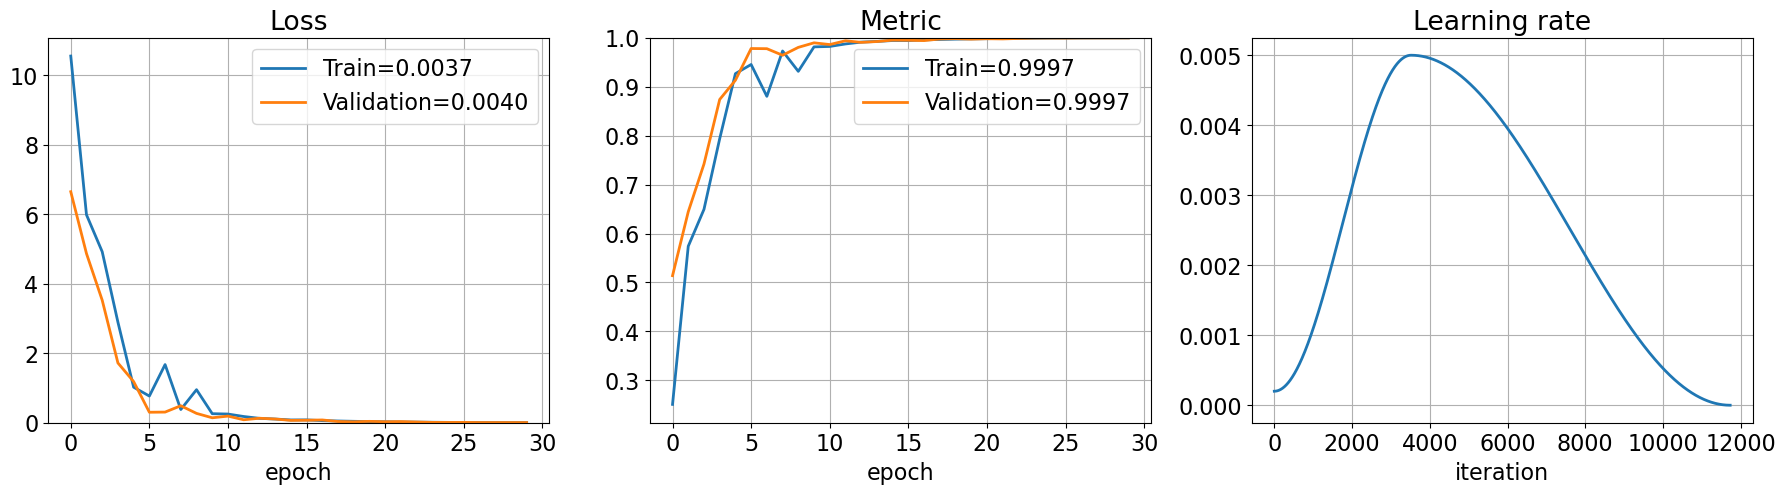

In [12]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()